In [1]:
import numpy as np
from numpy.random import randn
from collections import deque
#import rloutrading as rlou
import fx_triplets_trading as fx_triplet
from importlib import reload
import matplotlib.pyplot as plt
import torch

## DQN TRIPLETS

In [2]:
EURUSD = {
    'x_0' : 1.1 , 
    'x_min' : 0.9, 
    'x_max' : 1.3, 
    'buy_min' : -5, 
    'buy_max': 5, 
    'inventory_min' : -10, 
    'inventory_max' : 10, 
    'n_decimals_price' : 5, 
    'n_price' : 40, 
    'd_q': 0.5
}


GBPUSD = {
    'x_0' : 1.3 , 
    'x_min' : 1.1, 
    'x_max' : 1.5, 
    'buy_min' : -5, 
    'buy_max': 5, 
    'inventory_min' : -10, 
    'inventory_max' : 10, 
    'n_decimals_price' : 5, 
    'n_price' : 40, 
    'd_q' :  0.5
}


params = {
'a' : np.array([1.1,1.3]),
'B' : np.array([[0.01, -0.03],[-0.04, 0.01]]),
'c' : 0.1,
'rho' : np.array([0.1,0.1]),
'phi' : np.array([0.005,0.005]),
'alpha' : np.array([0.01,0.01]), 
 'T': 2.0,
 'dt': 0.2,
 'e_C': 20000.0,
 'e_D': 20000.0,
 'l_A': 20000.0,
 'l_B': 20000.0,
'eps_0' : 0.20, 
'n_decimals_time' :4, 
'K_replacement_freq' : 10, 
'delta' : 0.001, 
"n_batches": 64, #32
"config": 16, 
"buffer_size": 1_000
}

In [4]:
reload(fx_triplet)

EURUSD_pair = fx_triplet.PairFX(**EURUSD)
GBPUSD_pair = fx_triplet.PairFX(**GBPUSD)

dqntr = fx_triplet.DQN_Triplets(**params,
                                pair_1 = EURUSD_pair,
                                pair_2 = GBPUSD_pair, d_q = 0.5)

for i in range(dqntr.n_batches):
    dqntr.d_run_episode(i, 0.01)

In [5]:
iterations = 200
dqntr.K_replacement_freq = 500
dqntr.delta = 1/(iterations*10)
dqntr.optimizer.lr= 5e-9
dqntr.dq_learn(iterations, random_shock=True)

100%|██████████| 200/200 [02:05<00:00,  1.59it/s]


In [409]:
def create_landscape(model, pair, fixed_time, fixed_price, fixed_q,
                 fixed_action, price_grid=100):
    """
    Create the choice landscape for the FX-triples models for variying pair1 and fixed pair2
    
    Parameters
    ----------
    model: DQN_Triplets
        Triplets instance
    pair: PairFX
        Instance of the varying pair
    fixed_time: float
        Time to evaluate the landscape
    fixed_price: float
        Fixed price for the second pair
    fixed_q: float
        Fixed inventory for the second pair
    fixed_action: float
        Fixed action for the second pair
    price_grid: int
        Number of points to evaluate between pair.x_min
        and pair.x_max
    
    Returns
    -------
    torch.Tensor: choice landscape of options of size
                  (3, n_action, n_inventory)
                  The last entry of the first dimension
                  makes references to the actions taken
    """
    x_min, x_max = pair.x_min, pair.x_max
    q_min, q_max = pair.inventory_min, pair.inventory_max
    a_min, a_max = pair.buy_min, pair.buy_max
    it =(model.timesteps == fixed_time).argmax()
    d_q = pair.d_q
    d_price = (x_max - x_min) / price_grid
    
    prices = torch.arange(x_min, x_max + d_price, d_price)
    inventory = torch.arange(q_min, q_max + d_q, d_q)
    
    for ix_price, p1 in enumerate(prices.tolist()):
        for ix_inventory, q1 in enumerate(inventory.tolist()):
            possible_actions = torch.tensor(model.get_possible_actions(it, q1, pair))
            n_actions = len(possible_actions)
            # t, p1, p2, q1, q2, a1, a2
            input_tensor = torch.tensor([[t, p1, fixed_price, q1, fixed_q, action, fixed_action]
                                          for action in possible_actions])    
            X_in[ix_price, ix_inventory, :n_actions] = input_tensor
    
    # Map of indices of actions
    action_map = model.Q_M.forward(X_in)[..., -1].argmax(axis=-1)
    # From indices to values
    all_actions = dqntr.get_possible_actions(0, 0, pair)
    all_actions = action_map.apply_(lambda ix: int(all_actions[ix]))
    # Meshgrid of values
    X1, X2 = torch.meshgrid(prices, inventory)
    choice_landscape = torch.stack((X1, X2, action_map))
    return choice_landscape

In [406]:
pair = EURUSD_pair

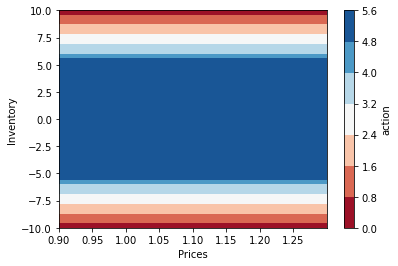

In [411]:
t, x, q, a = 0, 0, 0, 0
action_map = create_landscape(dqntr, pair, t, x, q, a)

plt.contourf(*action_map, cmap="RdBu")
plt.xlabel("Prices")
plt.ylabel("Inventory")
plt.colorbar(label="action")

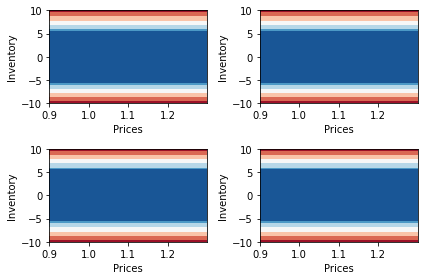

In [416]:
t_values = [0, 0.1, 0.5, 1]
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()

x, q, a = 0, 0, 0
for axi, t in zip(ax, t_values):
    action_map = create_landscape(dqntr, pair, t, x, q, a)

    axi.contourf(*action_map, cmap="RdBu")
    axi.set_xlabel("Prices")
    axi.set_ylabel("Inventory")
plt.tight_layout()

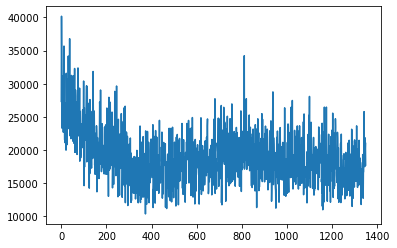

In [403]:
plt.plot(dqntr.error_history[:]) #

In [91]:
torch.save(dqntr.Q_M.state_dict(), "model_14112020_v2.pt")